In [1]:
import json
import pandas as pd
import re

In [2]:
with open('tioberny.txt', 'r', encoding='utf-16') as file:
    tweets = [json.loads(line) for line in file]

tioberny_tweets = pd.DataFrame(tweets)

In [3]:
with open('traficogt.txt', 'r', encoding='utf-16') as file:
    tweets = [json.loads(line) for line in file]

traficogt_tweets = pd.DataFrame(tweets)


In [4]:
print(tioberny_tweets.columns)
print(traficogt_tweets.columns)


Index(['id', 'id_str', 'url', 'date', 'user', 'lang', 'rawContent',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'bookmarkedCount', 'conversationId', 'conversationIdStr', 'hashtags',
       'cashtags', 'mentionedUsers', 'links', 'viewCount', 'retweetedTweet',
       'quotedTweet', 'place', 'coordinates', 'inReplyToTweetId',
       'inReplyToTweetIdStr', 'inReplyToUser', 'source', 'sourceUrl',
       'sourceLabel', 'media', 'card', '_type'],
      dtype='object')
Index(['id', 'id_str', 'url', 'date', 'user', 'lang', 'rawContent',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'bookmarkedCount', 'conversationId', 'conversationIdStr', 'hashtags',
       'cashtags', 'mentionedUsers', 'links', 'viewCount', 'retweetedTweet',
       'quotedTweet', 'place', 'coordinates', 'inReplyToTweetId',
       'inReplyToTweetIdStr', 'inReplyToUser', 'source', 'sourceUrl',
       'sourceLabel', 'media', 'card', '_type'],
      dtype='object')


Convertir a minúsculas

In [5]:
tioberny_tweets['rawContent'] = tioberny_tweets['rawContent'].str.lower()
traficogt_tweets['rawContent'] = traficogt_tweets['rawContent'].str.lower()


Quitar URLs

In [6]:
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

tioberny_tweets['rawContent'] = tioberny_tweets['rawContent'].apply(remove_urls)
traficogt_tweets['rawContent'] = traficogt_tweets['rawContent'].apply(remove_urls)


Quitar emoticones

In [7]:
def remove_emoticons(text):
    return re.sub(r'[^\w\s]', '', text)

tioberny_tweets['rawContent'] = tioberny_tweets['rawContent'].apply(remove_emoticons)
traficogt_tweets['rawContent'] = traficogt_tweets['rawContent'].apply(remove_emoticons)


Quitar signos de puntuación (exceptuando "@" y "#")

In [8]:
tioberny_tweets['rawContent'] = tioberny_tweets['rawContent'].str.replace(r'[^\w\s@#]', '', regex=True)
traficogt_tweets['rawContent'] = traficogt_tweets['rawContent'].str.replace(r'[^\w\s@#]', '', regex=True)


3.2. Extraer menciones, respuestas y retweets

In [9]:
# Crear listas para almacenar las interacciones
interactions = []

for index, row in tioberny_tweets.iterrows():
    user_id = row['user']['id_str']
    text = row['rawContent']
    
    # Extraer menciones
    mentions = re.findall(r'@(\w+)', text)  # Extraer nombres de usuario mencionados
    mentions = [mention.lower() for mention in mentions]  # Normalizar
    
    # Comprobar si es una respuesta o un retweet
    is_reply = row['inReplyToUser'] is not None
    is_retweet = row['retweetedTweet'] is not None

    interactions.append({
        'user_id': user_id,
        'mentions': mentions,
        'is_reply': is_reply,
        'is_retweet': is_retweet,
        'text': text
    })

interactions_df = pd.DataFrame(interactions)


3.3. Preprocesar datos eliminando duplicados y normalizando

In [10]:
# Eliminar duplicados
interactions_df.drop_duplicates(subset=['user_id', 'text'], inplace=True)

# Normalizar menciones
interactions_df['mentions'] = interactions_df['mentions'].apply(lambda x: [mention.lower() for mention in x])


3.4. Crear una estructura de datos eficiente para el análisis de redes

In [11]:
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.7 MB 2.8 MB/s eta 0:00:01
   ------------------------------ --------- 1.3/1.7 MB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 3.5 MB/s eta 0:00:00


In [12]:
import networkx as nx

# Crear un grafo dirigido
G = nx.DiGraph()

# Agregar nodos y aristas
for _, row in interactions_df.iterrows():
    user_id = row['user_id']
    mentions = row['mentions']
    
    # Añadir nodo para el usuario
    if not G.has_node(user_id):
        G.add_node(user_id)

    # Añadir aristas por cada mención
    for mention in mentions:
        G.add_edge(user_id, mention)  # Interacción dirigida

# Convertir a una matriz de adyacencia si es necesario
adjacency_matrix = nx.to_numpy_array(G)


In [13]:
total_tweets_tioberny = len(tioberny_tweets)
total_tweets_traficogt = len(traficogt_tweets)

print(f"Número total de tweets en tioberny: {total_tweets_tioberny}")
print(f"Número total de tweets en traficogt: {total_tweets_traficogt}")


Número total de tweets en tioberny: 5019
Número total de tweets en traficogt: 5605


In [14]:
# Obtener IDs de usuario de manera correcta
unique_users_tioberny = tioberny_tweets['user'].apply(lambda x: x['id_str']).nunique()
unique_users_traficogt = traficogt_tweets['user'].apply(lambda x: x['id_str']).nunique()

print(f"Número de usuarios únicos en tioberny: {unique_users_tioberny}")
print(f"Número de usuarios únicos en traficogt: {unique_users_traficogt}")



Número de usuarios únicos en tioberny: 2620
Número de usuarios únicos en traficogt: 2072


In [15]:
total_mentions_tioberny = interactions_df['mentions'].explode().nunique()
total_mentions_traficogt = interactions_df['mentions'].explode().nunique()

print(f"Número total de menciones en tioberny: {total_mentions_tioberny}")
print(f"Número total de menciones en traficogt: {total_mentions_traficogt}")


Número total de menciones en tioberny: 0
Número total de menciones en traficogt: 0


In [16]:
hashtags_tioberny = tioberny_tweets['hashtags'].explode().value_counts()
hashtags_traficogt = traficogt_tweets['hashtags'].explode().value_counts()

print("Hashtags más frecuentes en tioberny:")
print(hashtags_tioberny.head(10))

print("Hashtags más frecuentes en traficogt:")
print(hashtags_traficogt.head(10))


Hashtags más frecuentes en tioberny:
hashtags
URGENTE                         26
GuatemalaSaleAdelante           25
MinfinSaleAdelante              17
Guatemala                       15
Presupuesto2025                 14
UnPresupuestoParaLaPoblación    13
EnElPaísDCA                     12
NacionalesAGN                    8
ElEstor                          7
XelaNews                         7
Name: count, dtype: int64
Hashtags más frecuentes en traficogt:
hashtags
AHORA                     18
AhoraLH                   18
Guatemala                 16
RenuncienGolpistas        13
URGENTE                   10
guatemala                  9
ParoNacionalIndefinido     9
ParoNacionaIndefinido      8
Ahora                      8
LaHoraDeActualizarnos      8
Name: count, dtype: int64


In [17]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [18]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rentt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

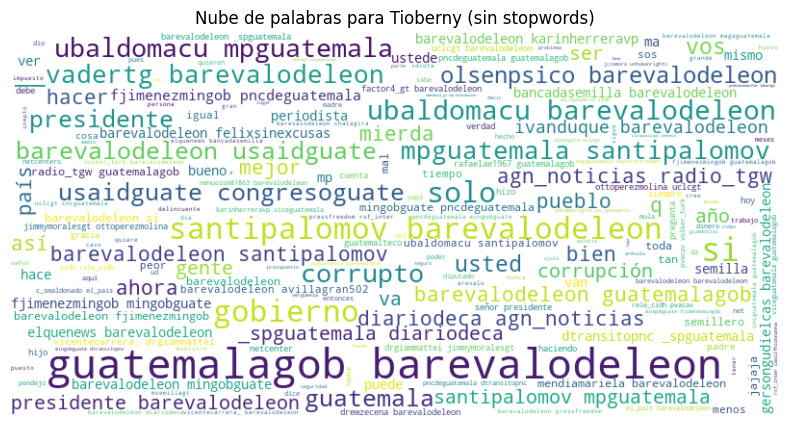

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Obtener stopwords en español
stop_words = set(stopwords.words('spanish'))

# Unir todos los textos para crear la nube, excluyendo las stopwords
text_tioberny = ' '.join(tioberny_tweets['rawContent'])
text_tioberny_filtered = ' '.join([word for word in text_tioberny.split() if word not in stop_words])

# Crear la nube de palabras
wordcloud_tioberny = WordCloud(width=800, height=400, background_color='white').generate(text_tioberny_filtered)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tioberny, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras para Tioberny (sin stopwords)')
plt.show()


## Inciso 5

In [36]:

lol = tioberny_tweets['mentionedUsers']

lol[0]

[{'id': 23664866,
  'id_str': '23664866',
  'username': 'usembassyguate',
  'displayname': 'US Embassy Guatemala',
  '_type': 'snscrape.modules.twitter.UserRef'},
 {'id': 1001171061831020545,
  'id_str': '1001171061831020545',
  'username': '48CantonesToto',
  'displayname': '48 Cantones Oficial',
  '_type': 'snscrape.modules.twitter.UserRef'},
 {'id': 262691982,
  'id_str': '262691982',
  'username': 'USAIDGuate',
  'displayname': 'USAID Guatemala',
  '_type': 'snscrape.modules.twitter.UserRef'},
 {'id': 1362391326,
  'id_str': '1362391326',
  'username': 'UEGuatemala',
  'displayname': 'Unión Europea en Guatemala',
  '_type': 'snscrape.modules.twitter.UserRef'},
 {'id': 945378369818058752,
  'id_str': '945378369818058752',
  'username': 'BArevalodeLeon',
  'displayname': 'Bernardo Arévalo',
  '_type': 'snscrape.modules.twitter.UserRef'}]

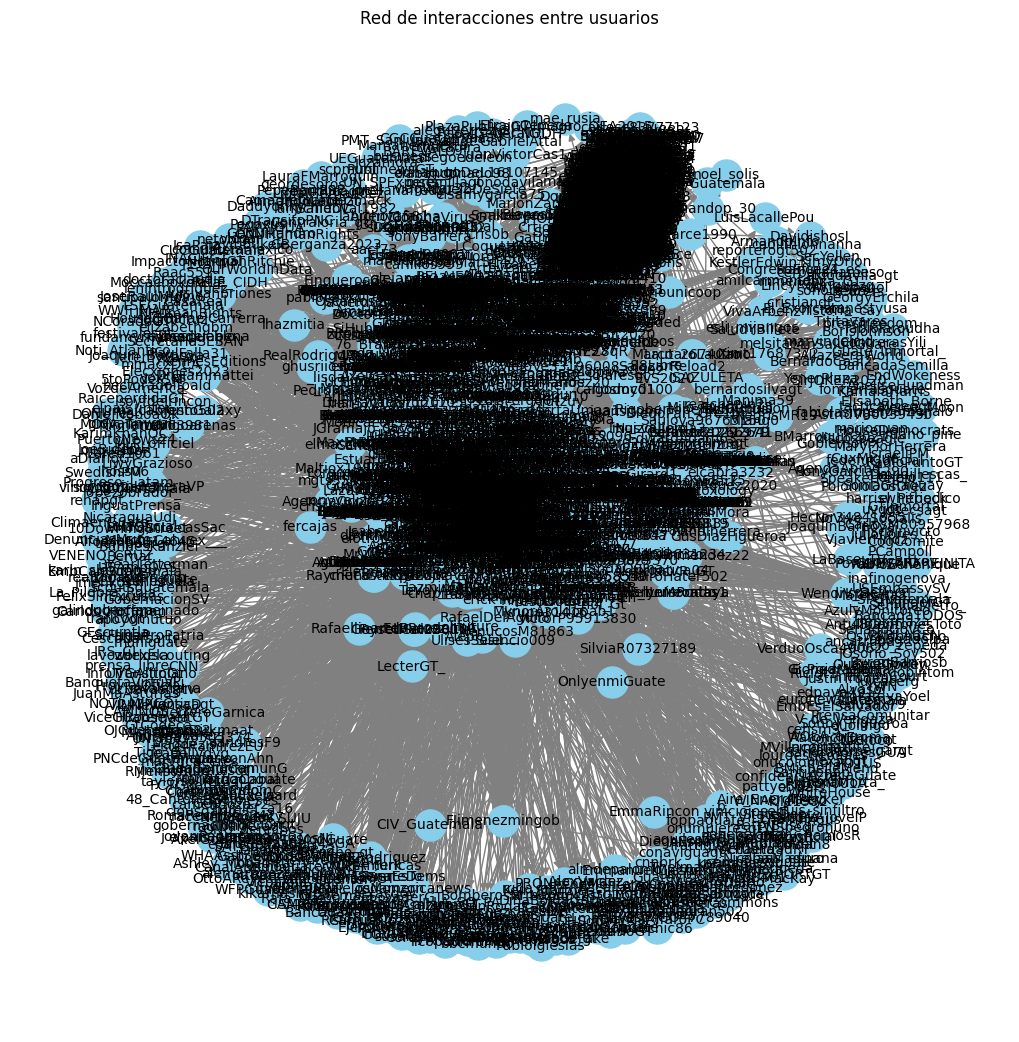

In [37]:
import networkx as nx
import matplotlib.pyplot as plt


# Crear un grafo dirigido
G = nx.DiGraph()

# Añadir nodos y aristas basados en las interacciones de los usuarios
for index, row in tioberny_tweets.iterrows():
    user = row['user']['username']  # Extraer el nombre de usuario del campo JSON
    mentioned_users = row['mentionedUsers']
    
    if mentioned_users:
        for mentioned_user in mentioned_users:
            mentioned_username = mentioned_user['username']  # Extraer el nombre de usuario mencionado
            G.add_edge(user, mentioned_username)  # Añadir una arista entre el usuario y el mencionado

# Visualización del grafo
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", edge_color="gray")
plt.title('Red de interacciones entre usuarios')
plt.show()


In [40]:
# Nodos más conectados (usuarios con más interacciones)
degree_centrality = nx.degree_centrality(G)
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]  # Top 10 nodos más conectados
print("Usuarios más conectados:")

for node, degree in top_nodes:
    print(f"  - {node}: {degree:.2f}")



Usuarios más conectados:
  - BArevalodeLeon: 0.81
  - GuatemalaGob: 0.20
  - UbaldoMacu: 0.13
  - santipalomov: 0.12
  - MPguatemala: 0.11
  - FJimenezmingob: 0.09
  - __VaderTG: 0.08
  - CongresoGuate: 0.07
  - mingobguate: 0.07
  - USAIDGuate: 0.06


In [47]:
# Densidad de la red
density = nx.density(G)
print("Densidad de la red:", density)

# Obtener el componente fuertemente conexo más grande del grafo
largest_scc = max(nx.strongly_connected_components(G), key=len)
subgraph = G.subgraph(largest_scc)

# Calcular el diámetro solo en el componente conexo más grande
if len(largest_scc) > 1:
    diameter = nx.diameter(subgraph.to_undirected())
    print("Diámetro de la red (componente conexo más grande):", diameter)
else:
    print("No se puede calcular el diámetro en un subgrafo de un solo nodo.")

# Coeficiente de agrupamiento (promedio) en todo el grafo
clustering_coefficient = nx.average_clustering(G.to_undirected())
print("Coeficiente de agrupamiento promedio:", clustering_coefficient)


Densidad de la red: 0.0012714250592210398
Diámetro de la red (componente conexo más grande): 5
Coeficiente de agrupamiento promedio: 0.3729830122015358


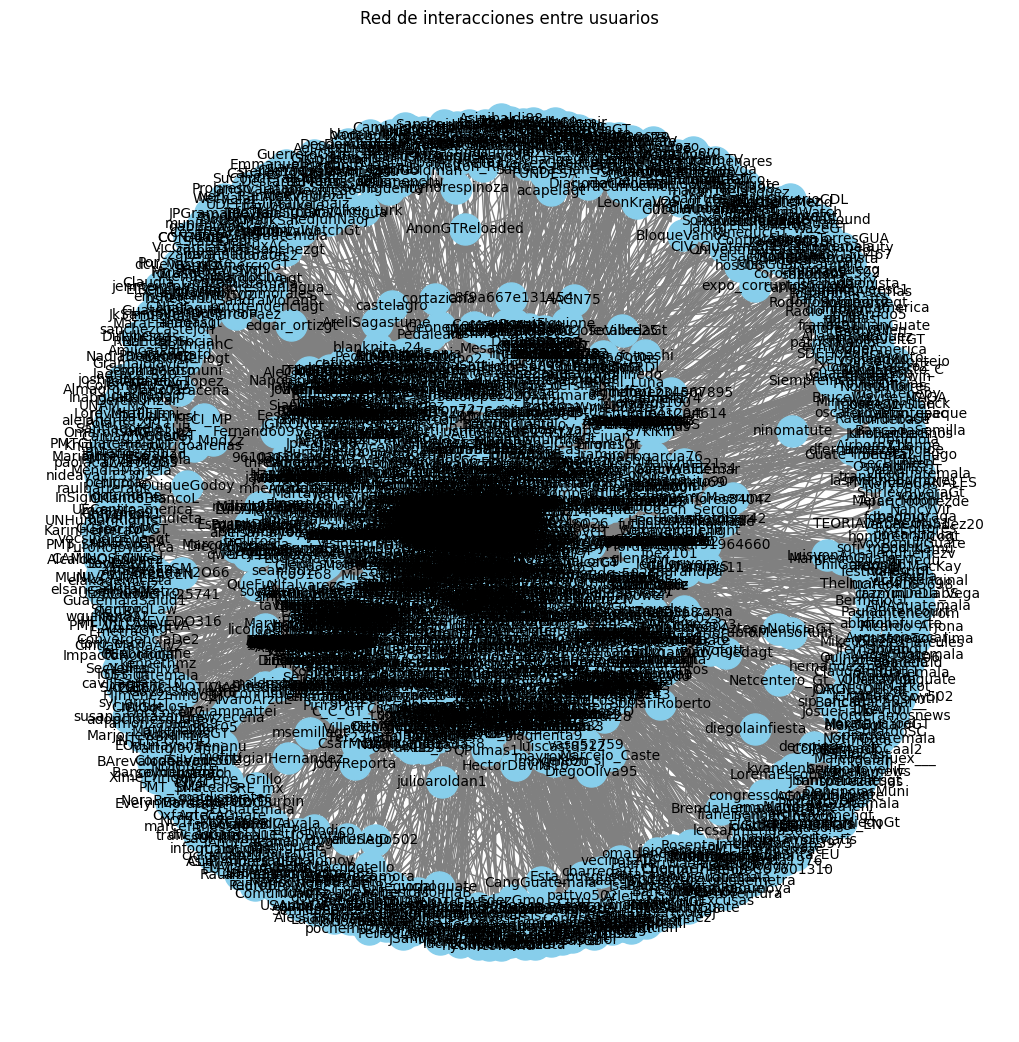

In [42]:

# Crear un grafo dirigido
G_trafico = nx.DiGraph()

# Añadir nodos y aristas basados en las interacciones de los usuarios
for index, row in traficogt_tweets.iterrows():
    user = row['user']['username']  # Extraer el nombre de usuario del campo JSON
    mentioned_users = row['mentionedUsers']
    
    if mentioned_users:
        for mentioned_user in mentioned_users:
            mentioned_username = mentioned_user['username']  # Extraer el nombre de usuario mencionado
            G_trafico.add_edge(user, mentioned_username)  # Añadir una arista entre el usuario y el mencionado

# Visualización del grafo
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_trafico)
nx.draw(G_trafico, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", edge_color="gray")
plt.title('Red de interacciones entre usuarios')
plt.show()


In [43]:
# Nodos más conectados (usuarios con más interacciones)
degree_centrality = nx.degree_centrality(G_trafico)
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]  # Top 10 nodos más conectados
print("Usuarios más conectados:")

for node, degree in top_nodes:
    print(f"  - {node}: {degree:.2f}")



Usuarios más conectados:
  - traficogt: 0.71
  - BArevalodeLeon: 0.12
  - DrGiammattei: 0.05
  - PrensaComunitar: 0.05
  - mildred_gaitan: 0.05
  - mmendoza_GT: 0.04
  - batallonjalapa: 0.04
  - MPguatemala: 0.04
  - amilcarmontejo: 0.03
  - lahoragt: 0.03


In [46]:
# Densidad de la red
density = nx.density(G_trafico)
print("Densidad de la red:", density)

# Obtener el componente fuertemente conexo más grande del grafo
largest_scc = max(nx.strongly_connected_components(G_trafico), key=len)
subgraph = G_trafico.subgraph(largest_scc)

# Calcular el diámetro solo en el componente conexo más grande
if len(largest_scc) > 1:
    diameter = nx.diameter(subgraph.to_undirected())
    print("Diámetro de la red (componente conexo más grande):", diameter)
else:
    print("No se puede calcular el diámetro en un subgrafo de un solo nodo.")

# Coeficiente de agrupamiento (promedio) en todo el grafo
clustering_coefficient = nx.average_clustering(G_trafico.to_undirected())
print("Coeficiente de agrupamiento promedio:", clustering_coefficient)


Densidad de la red: 0.0009929578225998227
Diámetro de la red (componente conexo más grande): 2
Coeficiente de agrupamiento promedio: 0.23393730512199898
